# Filtered power iteration

**by M. Wess, 2024**

*This Notebook is part of the `td_evp` [documentation](https://markuswess.github.io/td_evp) on the implementation of time-domain methods for resonance problems in [NGSolve](https://ngsolve.org).*

The notation of the following is based on the preprint 

* [[NW24a]](https://markuswess.github.io/td_evp/intro.html#id2) Lothar Nannen and Markus Wess. *A krylov eigenvalue solver based on filtered time domain solutions.* 2024. [arXiv:2402.08515](https://arxiv.org/abs/2402.08515).

## Introduction

This notebook is designed to present an implementation of the main ideas of time-domain methods for resonance problems by applying a simple power iteration to a filtered resonance toy problem (computing the eigenvalues of the dirichlet Laplacian on a rectangle). 

## Problem setting and definitions

We want to approximate the resonance problem to find $(\omega,u)$ with $\omega>0$

$$
-\Delta u = \omega^2 u,\quad +\text{homogeneous Dirichlet boundary conditions}
$$
on the domain $\Omega=(0,\pi)\times(0,\pi/2)$.

The eigenpairs of this problem are given by
$$
\omega_{l,k}=\sqrt{l^2+(2k)^2},\quad u_{l,k}=\sin(lx)\sin(2ky),\quad l,k=1,2,\ldots
$$

The problem is approximated by a Galerkin method, which leads to generalized the matrix eigenvalue problem
$$
\mathbf S \mathbf u = \omega^2\mathbf M \mathbf u.
$$

We apply a power iteration to the auxiliary problem

$$
\mathbf C u = \mu \mathbf u
$$

where the filtered discrete operator $\mathbf C$ is given by
 
$$C u = \tau \sum_{l=0}^{L-1}\alpha(\tau l)\mathbf y_l(\omega)$$

for a given time step $\tau>0$, a weight function
 $\alpha$ and $\mathbf y_l$ is the discrete time domain evolution (cf. [NW24a].(14))

## Defining spaces and bilinear forms

We choose a mass lumping finite element method for discretization, and assemble the stiffness and (inverse) mass matrix

In [52]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *


geo = OCCGeometry(Rectangle(pi,pi/2).Face(),dim=2)
mesh = Mesh(geo.GenerateMesh(maxh = 0.2))
Draw(mesh);

order = 2
fes = H1LumpingFESpace(mesh,order=order,dirichlet=mesh.Boundaries("default"))
print("number of dofs = ",fes.ndof)
u,v = fes.TnT()
mass = BilinearForm(u*v*dx(intrules=fes.GetIntegrationRules())).Assemble().mat
stiffness = BilinearForm(grad(u)*grad(v)*dx).Assemble().mat
massinv = mass.Inverse(freedofs = fes.FreeDofs())

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

number of dofs =  889


## Discrete filter function

We set some parameters and take a look at the resulting discrete filter. Note that in real life applications the time-step $\tau$ is chosen as large as possible to still obey the CFL condition. Here we just pick an arbitrary (small enough and thus stable) time-step.

first 10 resonances of the continuous problem:
2.23606797749979
2.8284271247461903
3.605551275463989
4.123105625617661
4.47213595499958
4.47213595499958
5.0
5.385164807134504
5.656854249492381
6.082762530298219


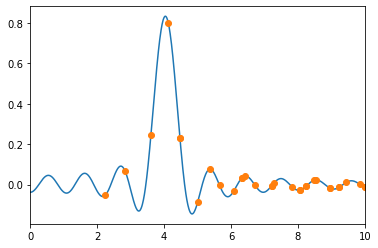

In [66]:
import numpy as np
import matplotlib.pyplot as pl


w_min = 3.8
w_max = 4.3

tau = 0.02

L = 300


weightf = lambda t: 4/np.pi*np.cos((w_max+w_min)/2*t)*(w_max-w_min)/2*np.sinc((w_max-w_min)/2*t/np.pi)

weights = weightf(tau*np.arange(L))

def beta(omega):
    if np.isscalar(omega):
        q = 1
    else:
        q = np.ones(omega.shape)
    
    q_old = q
    out = tau*weights[0]*q
    for alpha in weights[1:]:
        q_new = 2*q-tau**2*omega**2*q-q_old
        q_old = q
        q = q_new
        out += tau*alpha*q
    return out

omegas = np.arange(0,10,0.01)

betas = beta(omegas)
pl.plot(omegas,betas);
evs = np.sqrt(np.array([l**2+(2*k)**2 for l in range(1,10) for k in range(1,10)]))
pl.plot(evs,beta(evs),'o')
pl.xlim((0,10))
print("first 10 resonances of the continuous problem:")
for res in np.sort(evs)[:10]:
    print(res)

Looking at the discrete filter above and the values of $\beta(\omega_{l,k})$ (i.e., the eigenvalues of the filtered operator $\mathbf C$) shows that applying a power iteration to $\mathbf C$ will yield an approximation to the eigenfunction approximating $u_{1,2}=\sin(x)\sin(4y)$ corresponding to $\omega_{1,2}=\sqrt{17}$.

## Defining the filtered operator

One application of the filtered operator $\mathbf C$ propagates the given initial data and applies the filter over the time evolution.

In [64]:
u = GridFunction(fes)
u.vec.SetRandom()
tmpvec = u.vec.CreateVector()
u_old = u.vec.CreateVector()
u_new = u.vec.CreateVector()




drawevery = 1

def C(uvec, out, drawscene = None):   
    u_old.data = uvec
    
    out.data = tau*weights[0]*uvec
    for i in range(1,len(weights)):
        alpha = weights[i]
        u_new.data = 2*uvec-u_old
        u_new.data -= tau**2*massinv@stiffness*uvec
        u_new.data[~fes.FreeDofs()] = 0.
        u_old.data = uvec
        uvec.data = u_new
        out.data += tau*alpha*uvec
        if drawscene:
            if not i%drawevery:
                drawscene.Redraw()

## Applying the power iteration

In [65]:
N = 10


for i in range(N):
    print("## step ",i)
    scene = Draw(u);
    C(u.vec,tmpvec,scene)
    norm = tmpvec.Norm()
    u.vec.data = 1/norm*tmpvec
    tmpvec.data = mass * u.vec
    
    normm = InnerProduct (u.vec,tmpvec)
    tmpvec.data = stiffness * u.vec    
    norms = InnerProduct (u.vec,tmpvec)
    
    approx_w = sqrt(norms/normm)
    print("approximated eigenvalue: ",approx_w)

## step  0


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  3.4722963667414426
## step  1


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  3.809172198380957
## step  2


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.062817560251173
## step  3


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.1166467971842104
## step  4


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.12231518621999
## step  5


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.122847888520569
## step  6


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.12289736966135
## step  7


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.122901960066693
## step  8


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.122902385814379
## step  9


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

approximated eigenvalue:  4.122902425295543
